## **EJERCICIO PRÁCTICO TEXT MINING:**

### **Shared-task Profner: análisis de textos para detectar y predecir menciones de profesiones en tweets.**

NOTA: Python Notebook realizado en Google Colab

In [6]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: profner/subtask-1/test-background-txt-files/1243953060050763778.txt  
  inflating: profner/subtask-1/test-background-txt-files/1243988693947486209.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244173600753618945.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244319340062822405.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247000104193712129.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247263989249212416.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247465550931988482.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249075777544556545.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249253729720766466.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249964965546668034.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249980196838682624.txt  
  inflating: profner/subta

Funciones de carga y preparación de datos

In [7]:
import sys
import os
import pandas as pd
import numpy as np
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt
    que se introduce en su entrada.
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()

  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

In [8]:
!pip install textacy
# Instalamos spacy y uno de sus modelos
!pip install spacy
# Descargamos modelos pre-entrenados de spacy en español.
!python -m spacy download es_core_news_sm
# Instalamos imbalanced-learn para utilizar si librería SMOTE
!pip install imbalanced-learn

2023-10-27 16:20:05.974070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 16:20:05.974144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 16:20:05.974179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 16:20:05.983419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 16:20:07.264667: W tensorflow/compiler/

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob).
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports


In [9]:
 !pip install contractions
 #!pip install nltk

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import contractions
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe.

In [11]:
profner_path = "./profner/"
dataset = get_profner_data(profner_path)

In [12]:
dataset.head(10)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train
5,1266846025576218626,"Lo nunca visto, aqui en España, por lo q se ve...",0,train
6,1276842713858502663,#Coronavirus: un nuevo estudio descubre que ta...,0,train
7,1270064252234215424,Esto será vestigio arqueológico del pelotazo a...,0,train
8,1252741192577581056,Repartidores teniendo que trabajar en medio de...,1,train
9,1260266403409670144,@carlesenric @salvadorilla Es imprescindible d...,1,train


## 2. Análisis exploratorio (EDA)

En este apartado pretendemos realizar un análisis de los datos previo a la normalización de los mismos. Este análisis nos va a permitir extraer información relevante del dataset, así como posibles inconvenientes que serán solucionados llegado el caso.

* **Número de documentos y columnas:**

Comenzamos mostrando el número de documentos, o lo que es lo mismo, el número de filas del data frame:


In [13]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))
print("El dataset tiene {} columnas".format(dataset.shape[1]))

Tenemos un conjunto de 8000 documentos
El dataset tiene 4 columnas


* **Número de documentos duplicados:**

Despues, comprobamos y eliminamos las filas con algún valor vacío (NA) y quitaremos los duplicados.


In [14]:
print("Existen {} tweets duplicados".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} tweets".format(dataset.shape[0]))

Existen 0 tweets duplicados
Despues de quitar duplicados tenemos un conjunto de 8000 tweets


In [15]:
print("Existen {} id_tweets duplicados".format(np.sum(dataset.duplicated(subset=["tweet_id"]))))


Existen 0 id_tweets duplicados


Comprobaramos que no hayan quedado Nulls en ningunas de las 4 columnas del dataset:

In [16]:
# Nulos totales en el dataset:
dataset.isnull().sum().sum()

0

In [17]:
# Nulos totales por columna (en este caso no haría falta porque no hay nulos en todo el dataset):
print("Hay {} valores vacíos en los id_tweets, {} valores vacíos en los tweets, {} valores vacíos en las etiquetas en los datos y {} valores vacíos en columna de train_test".format(np.sum(dataset.isnull())[0],
                                                                                                                                                                                        np.sum(dataset.isnull())[1],
                                                                                                                                                                                          np.sum(dataset.isnull())[2],
                                                                                                                                                                                            np.sum(dataset.isnull())[3]))

Hay 0 valores vacíos en los id_tweets, 0 valores vacíos en los tweets, 0 valores vacíos en las etiquetas en los datos y 0 valores vacíos en columna de train_test


* **Número de documentos por cada set:**

Contamos el número de documentos que pertenecen al set de train/valid

In [18]:
print(dataset['set'].value_counts())

# Número de elementos de cada set:
dataset.groupby(['set']).count()

train    6000
valid    2000
Name: set, dtype: int64


,tweet_id,tweet_text,label
set,,,
train,6000,6000,6000
valid,2000,2000,2000


* **Número de documentos por cada clase:**

Contamos el número de elementos de cada clase, esto se hace muy fácil con un groupby de la columna 'label' y un conteo posterior. También se puede hacer con un value_counts sobre la serie de la etiqueta.

In [19]:
print(dataset["label"].value_counts())

# Número de elementos de cada clase:
dataset.groupby(['label']).count()

0    6130
1    1870
Name: label, dtype: int64


,tweet_id,tweet_text,set
label,,,
0,6130,6130,6130
1,1870,1870,1870


Observamos que no tenemos un dataset muy balanceado, ya que tenemos aproximadamente 6000 tweets en los que NO se menciona a profesionales (valor 0), frente a solo aproximadamente 2000 tweets en los que SÍ se menciona a profesionales (valor 1).

¡¡Esto nos puede dar problemas en el entrenamiento de los modelos!! 😞 Por lo que tendremos que balancearlo nosotros más adelante (y solo en el set de train)


Vamos a dibujar un histograma con las clases:

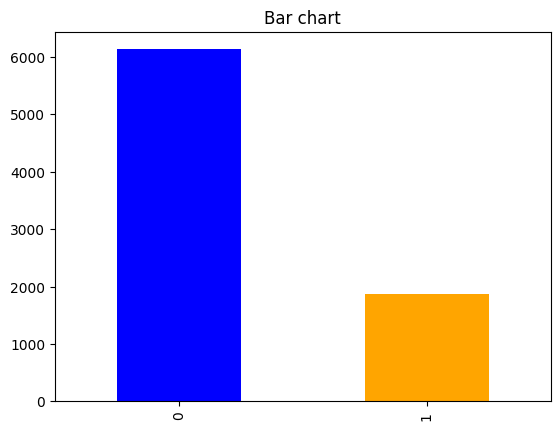

In [20]:
ax, fig = plt.subplots()
etiquetas = dataset.label.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

* **Distribución de la longitud de los tweet en caracteres:**

Para seguir con el análisis exploratorio, vamos a hacer un cálculo típico: la longitud de cada uno de los textos de los documentos para despues dibujar su histograma.

In [21]:
# Comenzamos creando las columnas que van a almacenar las longitud en caracteres y en tokens de los documentos del corpus:

dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

<ipython-input-22-087812f4009a>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(dataset[dataset["label"]==0].char_len, hist=True, label="no profesion")
<ipython-input-22-087812f4009a>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt2 = sns.distplot(dataset[dataset["label"]==1].char_len, hist=True

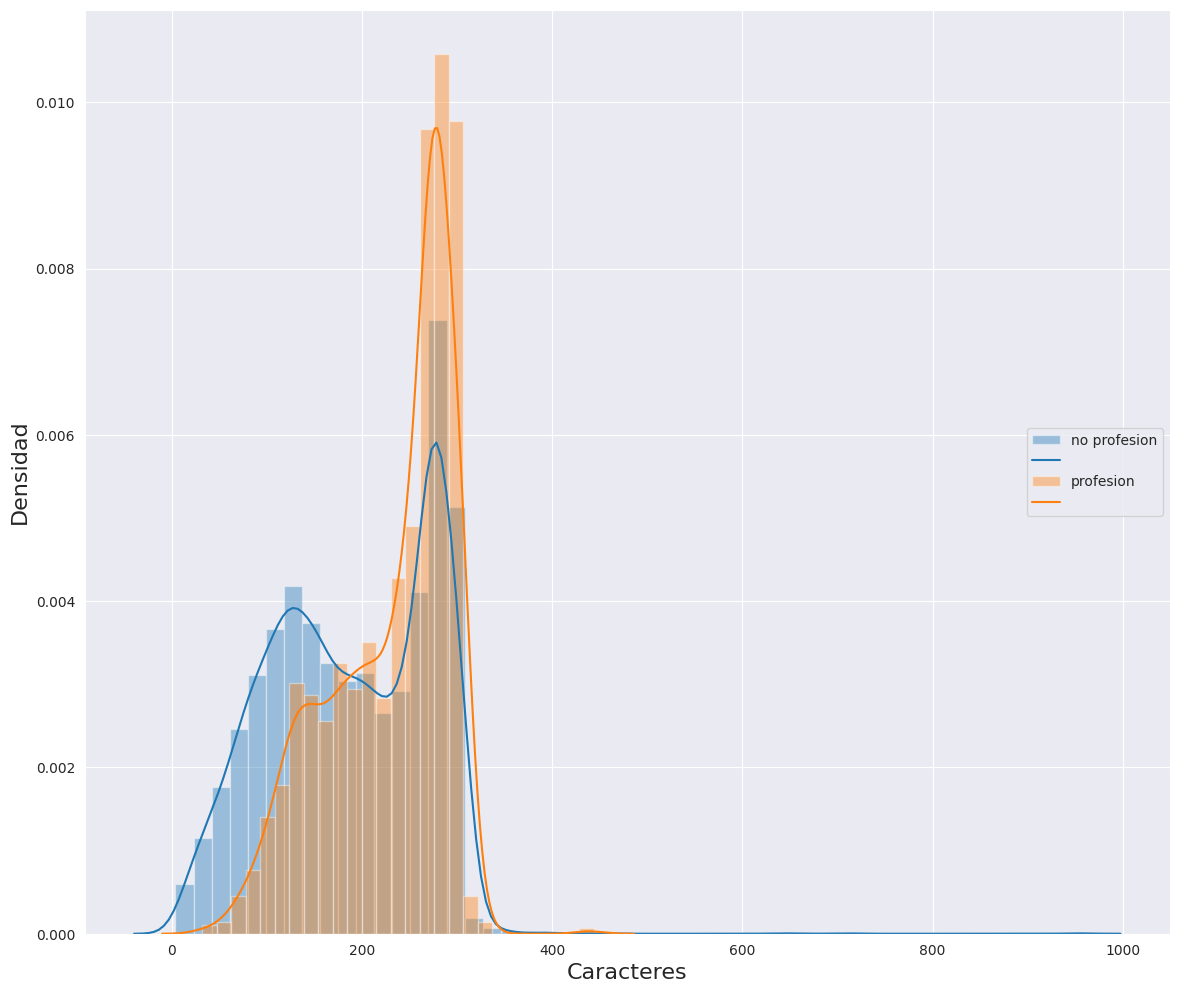

In [22]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(dataset[dataset["label"]==0].char_len, hist=True, label="no profesion")
plt2 = sns.distplot(dataset[dataset["label"]==1].char_len, hist=True, label="profesion")
plt.legend(labels=['no profesion',"",'profesion',""], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()


Vemos que las distribuciones de longitud de los tweets cambian en función de si mencionan profesiones o no, aunque ambas etiquetas siguen más o menos la misma distribución.

Esto hace que, al no haber separación de las variables por longitud, no podremos entrenar un "clasificador" teniendo en cuenta únicamente una regla de la longitud de los tweets (como p.ej. `if len(noticia)>50 "noprof" else "prof"`)

Esto significa que una vez que tengamos los textos representados numéricamente, haremos sobre el set de TRAIN la técnica SMOTE (librería imblearn, imbalanced learn), que lo que hace es duplicar de forma inteligente algunos registros para que el dataset esté balanceado a nivel de labels.

**Como no hemos podido deducir nada del gráfico anterior únicamente utilizando el número de caracteres, podemos utilizar el número de adjetivos, ya que además, estamos ante un caso e Twitter** (mismo número de adjetivos en una categoría y otra)

## 3. Preprocesado y Normalización

Vamos a proceder a normalizar los datos. Para ello vamos a generar pequeñas funciones que nos permitan:
- Eliminar espacios extra.
- Transformar a minúsculas.
- Tokenizar.
- Reemplazar contractions.
- Lematizar tokens.
- Eliminar stopwords.
- Eliminar sígnos de puntuación.

In [23]:

# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

# Tokenizador
from nltk.tokenize import TweetTokenizer     # utilizamos un tokenizador especial para tweets porque el resto no funcionan bien con este formato
def tokenization(text):
  tokenizer = TweetTokenizer()
  tokens = tokenizer.tokenize(text)
  return tokens


# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    for t in text.split():
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words)
    return expanded_text

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('spanish'))
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words


# Lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  #disable desabilita algunos de los elementos del pipeline de spacy para que no se ejecute y así no tarde tanto
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)

# Stemming
import string
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens

Podríamos generar una función de transformación que aglutinara todas las anteriores y pasársela al siguiente paso (TfidfVectorizer) en el campo analyzer. Para ver el proceso de cada uno de los pasos lo haremos paso a paso:


In [24]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

# Espacios
dataset["normaliza"] = dataset['tweet_text'].progress_apply(lambda x: eliminar_espacios(x))
# To Lower. Pasa a minusculas las letras.
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: texto_to_lower(x))
# Contracciones: en este dataset no es necesario porque no estamos tratando con textos en inglés
#dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: replace_contraction(x))
# Tokenizar
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: tokenization(x))
# Quitar Stopwords. Tokens que no nos aportan valor a nuestro modelo, por ejemplo preposiciones, conjunciones, pronombre personales.
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: quitar_stopwords(x))
# Quitar puntuación
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: quitar_puntuacion(x))
# Lematización (mediante spacy) Aqui vamos a hacer las formas canonicas, reducimos la variabilidad de palabras.
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: lematizar(x))

# Stemming tardaría menos que lemmatization pero es menos eficaz
#dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: stem(x))



# Tokenizar de nuevo porque el formato de token se ha perdido en el proceso
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: tokenization(x))

dataset["normaliza"]




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

0       [china, libera, pandemia, libera, ovnis, argen...
1       [san, francisco, eeuu, hace, 100, años, tras, ...
2       [porfi, poneo, mascarilla, 28, nuevas, cancion...
3       [nuevo, covid, normas, reglas, recibimiento, c...
4       [si, confinamiento, dejado, tocada, estabilida...
                              ...                        
7995    [nuevos, infectado, coronavirus, multiplican, ...
7996    [ayuso, adjudica, dedo, contrato, euros, hacer...
7997    [mese, encerrado, puede, viajar, provincia, ir...
7998    [gobierno, prohíbe, ley, lis, despidos, crisis...
7999                       [rasgos, psicológicos, llevas]
Name: normaliza, Length: 8000, dtype: object

In [25]:
# Función para eliminar tokens muy pequeños:
def eliminate_short_tokens(tokens):
  lista_out = [token for token in tokens if len(token)>2]
  return lista_out


dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: eliminate_short_tokens(x))

dataset["normaliza"]

  0%|          | 0/8000 [00:00<?, ?it/s]

0       [china, libera, pandemia, libera, ovnis, argen...
1       [san, francisco, eeuu, hace, 100, años, tras, ...
2       [porfi, poneo, mascarilla, nuevas, cancione, a...
3       [nuevo, covid, normas, reglas, recibimiento, c...
4       [confinamiento, dejado, tocada, estabilidad, m...
                              ...                        
7995    [nuevos, infectado, coronavirus, multiplican, ...
7996    [ayuso, adjudica, dedo, contrato, euros, hacer...
7997    [mese, encerrado, puede, viajar, provincia, re...
7998    [gobierno, prohíbe, ley, lis, despidos, crisis...
7999                       [rasgos, psicológicos, llevas]
Name: normaliza, Length: 8000, dtype: object

<ipython-input-26-99899e61d450>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(dataset[dataset["label"]==0]["token_len"], hist=True, label="no profesion")
<ipython-input-26-99899e61d450>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt2 = sns.distplot(dataset[dataset["label"]==1]["token_len"], h

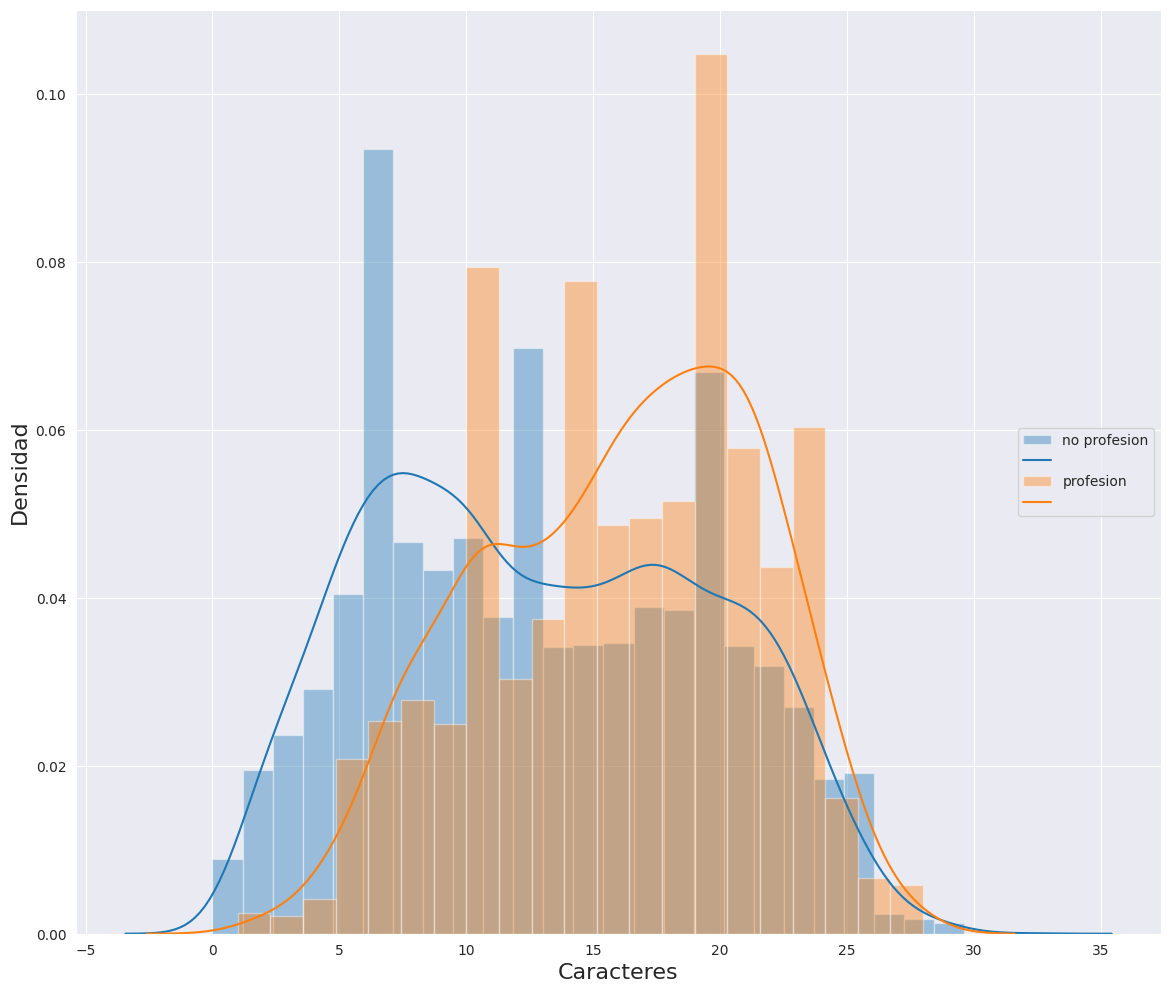

In [26]:
dataset["token_len"] = dataset["normaliza"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
plt1 = sns.distplot(dataset[dataset["label"]==0]["token_len"], hist=True, label="no profesion")
plt2 = sns.distplot(dataset[dataset["label"]==1]["token_len"], hist=True, label="profesion")
plt.legend(labels=['no profesion',"",'profesion',""], loc = 5)

# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

Como ya veíamos antes, las dos distribuciones de tweets (con y sin menciones de profesiones) son muy parecidas, por lo que no podemos diferenciarlas solo por la longitud de los tweets o la longitud de los tokens una vez normalizados.

In [27]:
dataset.head()

,tweet_id,tweet_text,label,set,char_len,normaliza,token_len
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,"[china, libera, pandemia, libera, ovnis, argen...",9
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,"[san, francisco, eeuu, hace, 100, años, tras, ...",10
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,"[porfi, poneo, mascarilla, nuevas, cancione, a...",8
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225,"[nuevo, covid, normas, reglas, recibimiento, c...",19
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138,"[confinamiento, dejado, tocada, estabilidad, m...",13


Se ha hecho el preprocesado, y antes de introducirlo a TFIDF vamos a generar una frase de cada una de las listas de tokens, para utilizar el propio tokenizador de TFIDF.

In [28]:
# Podemos agregar espacios entre los tokens para juntar todos los tokens en una sola lista -> columna nueva "clean_text" para utilizar en el vectorizador
dataset["clean_text"] = dataset["normaliza"].progress_apply(lambda x: " ".join(x))
dataset["clean_text"]

  0%|          | 0/8000 [00:00<?, ?it/s]

0       china libera pandemia libera ovnis argentina l...
1       san francisco eeuu hace 100 años tras vivir pa...
2       porfi poneo mascarilla nuevas cancione artista...
3       nuevo covid normas reglas recibimiento comerci...
4       confinamiento dejado tocada estabilidad mental...
                              ...                        
7995    nuevos infectado coronavirus multiplican casi ...
7996    ayuso adjudica dedo contrato euros hacer vídeo...
7997    mese encerrado puede viajar provincia restaura...
7998    gobierno prohíbe ley lis despidos crisis coron...
7999                           rasgos psicológicos llevas
Name: clean_text, Length: 8000, dtype: object

In [29]:
dataset.head()


,tweet_id,tweet_text,label,set,char_len,normaliza,token_len,clean_text
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,"[china, libera, pandemia, libera, ovnis, argen...",9,china libera pandemia libera ovnis argentina l...
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,"[san, francisco, eeuu, hace, 100, años, tras, ...",10,san francisco eeuu hace 100 años tras vivir pa...
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,"[porfi, poneo, mascarilla, nuevas, cancione, a...",8,porfi poneo mascarilla nuevas cancione artista...
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225,"[nuevo, covid, normas, reglas, recibimiento, c...",19,nuevo covid normas reglas recibimiento comerci...
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138,"[confinamiento, dejado, tocada, estabilidad, m...",13,confinamiento dejado tocada estabilidad mental...


## 4. Vectorización


Como vamos a utilizar el vector TF-IDF, será necesario que incorporemos al modelo características adicionales de sentimiento -> Utilizaremos la librería Spanish Emotion Lexicon (SEL), que contiene 2036 palabras clasificadas en 6 estados de ánimo diferente.



In [30]:
# Nos descargamos los datos de la web de Grigori Sidorov.
url_path = "https://www.cic.ipn.mx/~sidorov/SEL.txt"
sel_lexicon = pd.read_csv(url_path,sep="\t", encoding="latin-1")

In [31]:
# La categoría "Alegría" y "Sorpresa" se mapearán a "positive" y el resto a "negative":
dicc_mapping = {"Alegría":"positive",
                "Sorpresa":"positive",
                "Tristeza":"negative",
                "Enojo":"negative",
                "Miedo":"negative",
                "Repulsión":"negative"}

sel_lexicon["Categoría"] = sel_lexicon["Categoría"].map(dicc_mapping)

In [32]:
# Hacemos dos categorias una con positiva y otra con negativa.
positive_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="positive"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="positive"][' PFA']))
negative_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="negative"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="negative"][' PFA']))

In [33]:
def calculate_sentiment(frase, positive_words, negative_words):
  """
  Función para calcular el score de sentimiento de una frase

  Args:
    frase [str]: Frase pre-preprocesada en español. Debe venir lematizada.
    positive_words [dict]: Diccionario de palabras positivas extraidas de SEL
    negative_words [dict]: Diccionario de palabras negativas extraídas de SEL

  Out:
    Sentiment score
  """
  score = 0
  for i in frase.split():
    if i in positive_words:
      score = score + float(positive_words[i])
    elif i in negative_words:
      score = score - float(negative_words[i])
    else:
      score = score + 0

  return score


In [34]:
# Creamos una lista para almacenar los resultados de sentimiento
sentimientos = []

# Aplicamos la función para calcular el score del sentimiento a cada texto
for texto in dataset["clean_text"]:
    valor_sentimiento = calculate_sentiment(texto, positive_words, negative_words)
    sentimientos.append(valor_sentimiento)

# Agregamos los resultados de sentimiento como una nueva columna en el DataFrame
dataset['sentimiento'] = sentimientos

dataset.head(10)

,tweet_id,tweet_text,label,set,char_len,normaliza,token_len,clean_text,sentimiento
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,"[china, libera, pandemia, libera, ovnis, argen...",9,china libera pandemia libera ovnis argentina l...,0.000
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,"[san, francisco, eeuu, hace, 100, años, tras, ...",10,san francisco eeuu hace 100 años tras vivir pa...,0.630
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,"[porfi, poneo, mascarilla, nuevas, cancione, a...",8,porfi poneo mascarilla nuevas cancione artista...,0.000
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225,"[nuevo, covid, normas, reglas, recibimiento, c...",19,nuevo covid normas reglas recibimiento comerci...,0.000
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138,"[confinamiento, dejado, tocada, estabilidad, m...",13,confinamiento dejado tocada estabilidad mental...,0.000
5,1266846025576218626,"Lo nunca visto, aqui en España, por lo q se ve...",0,train,280,"[nunca, visto, aqui, españa, resucitan, vez, v...",20,nunca visto aqui españa resucitan vez veo meno...,-0.563
6,1276842713858502663,#Coronavirus: un nuevo estudio descubre que ta...,0,train,215,"[nuevo, estudio, descubre, paciente, covid, si...",12,nuevo estudio descubre paciente covid sintomát...,-0.630
7,1270064252234215424,Esto será vestigio arqueológico del pelotazo a...,0,train,84,"[vestigio, arqueológico, pelotazo, día, siguie...",7,vestigio arqueológico pelotazo día siguiente c...,0.000
8,1252741192577581056,Repartidores teniendo que trabajar en medio de...,1,train,190,"[repartidore, trabajar, medio, pandemia, encer...",15,repartidore trabajar medio pandemia encerrado ...,0.000
9,1260266403409670144,@carlesenric @salvadorilla Es imprescindible d...,1,train,245,"[imprescindible, desescalada, criterio, sanita...",17,imprescindible desescalada criterio sanitario ...,0.000


In [35]:
# Definimos la variable de categorías:
dataset['label'] = dataset["label"].values.astype(np.float32)

dataset.dtypes

tweet_id         int64
tweet_text      object
label          float32
set             object
char_len         int64
normaliza       object
token_len        int64
clean_text      object
sentimiento    float64
dtype: object

In [36]:
# Separar entre set train/valid porque queremos un vectorizador para cada conjunto (si no, luego el vector_data no lo podemos dividir en train/valid según el set)
Train = dataset[dataset['set']=='train']
Train['set'].value_counts()

train    6000
Name: set, dtype: int64

In [37]:
Train.head()

,tweet_id,tweet_text,label,set,char_len,normaliza,token_len,clean_text,sentimiento
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0.0,train,87,"[china, libera, pandemia, libera, ovnis, argen...",9,china libera pandemia libera ovnis argentina l...,0.00
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0.0,train,90,"[san, francisco, eeuu, hace, 100, años, tras, ...",10,san francisco eeuu hace 100 años tras vivir pa...,0.63
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0.0,train,95,"[porfi, poneo, mascarilla, nuevas, cancione, a...",8,porfi poneo mascarilla nuevas cancione artista...,0.00
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0.0,train,225,"[nuevo, covid, normas, reglas, recibimiento, c...",19,nuevo covid normas reglas recibimiento comerci...,0.00
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0.0,train,138,"[confinamiento, dejado, tocada, estabilidad, m...",13,confinamiento dejado tocada estabilidad mental...,0.00


In [38]:
Valid = dataset[dataset['set']=='valid']
Valid['set'].value_counts()

valid    2000
Name: set, dtype: int64

In [39]:
Valid.head()

,tweet_id,tweet_text,label,set,char_len,normaliza,token_len,clean_text,sentimiento
6000,1279974120902590466,@JimmieJohnson resultó positivo en la prueba d...,0.0,valid,143,"[resultó, positivo, prueba, covid, correrá, do...",11,resultó positivo prueba covid correrá domingo ...,0.000
6001,1282343525078663168,#Mundo: El Reino Unido podría empezar a implem...,0.0,valid,215,"[reino, unido, podría, empezar, implementar, v...",17,reino unido podría empezar implementar vacuna ...,0.000
6002,1278069425472704512,🇵🇪 | URGENTE - CORONAVIRUS: Perú reporta 2848 ...,0.0,valid,76,"[urgente, coronavirus, perú, reporta, 2848, ca...",8,urgente coronavirus perú reporta 2848 casos úl...,0.000
6003,1274677343680946176,Las limpiadoras de hospitales son las olvidada...,1.0,valid,276,"[limpiadora, hospitale, olvidada, covid, días,...",16,limpiadora hospitale olvidada covid días prote...,-0.562
6004,1270626757327151105,"💡Carina, el chatbot desarrollado por @1_millio...",0.0,valid,211,"[carina, chatbot, desarrollado, proporcionar, ...",15,carina chatbot desarrollado proporcionar infor...,0.000



Queremos que la funcionalidad 'TfidfVectorizer' tenga en cuenta los siguientes aspectos:

*  No considerar procesados ya hechos (lowercase y stopwords)
*   Para evitar overfitting vamos a usar la **"regla" del 10 por ciento**. Por lo que van a ser **600** features como máximo (10% de 6000 de train)
* Considerar unigramas, bigramas y trigramas
* Que el sistema no considere los elementos que salgan en menos del **1% de los documentos**.


In [40]:
# Vectorizador para el conjunto de Train
vectorizador = TfidfVectorizer(lowercase = False, stop_words =None,
                               min_df=0.001, ngram_range = (1,3), max_features = 600)  #10% de los 6000 documentos de Train

vector_data = vectorizador.fit_transform(Train["clean_text"])

vector_data

<6000x600 sparse matrix of type '<class 'numpy.float64'>'
	with 35962 stored elements in Compressed Sparse Row format>

In [41]:
print(vector_data)

  (0, 381)	0.48593342264435907
  (0, 64)	0.8739958287984783
  (1, 550)	0.36136552182414095
  (1, 36)	0.346125575610119
  (1, 0)	0.43174353096127804
  (1, 231)	0.32595662405922543
  (1, 158)	0.43174353096127804
  (1, 487)	0.4753505119512471
  (1, 381)	0.21119010987995132
  (2, 363)	0.8758592956275681
  (2, 300)	0.48256656977331147
  (3, 358)	0.3386852279886117
  (3, 361)	0.2943144353139491
  (3, 86)	0.35931817697765916
  (3, 290)	0.239607513316011
  (3, 50)	0.2881423115344928
  (3, 299)	0.3480585925089263
  (3, 150)	0.22991325106244756
  (3, 177)	0.3497851828773076
  (3, 359)	0.3572775972082627
  (3, 96)	0.15704845280905042
  (3, 364)	0.28365113445414897
  (4, 401)	0.4719603459202798
  (4, 446)	0.39110735855902534
  (4, 508)	0.4606320656407744
  :	:
  (5993, 381)	0.2789894423526874
  (5994, 152)	0.5233673966275852
  (5994, 100)	0.47238807584260256
  (5994, 215)	0.3927512871753146
  (5994, 34)	0.43357763724809334
  (5994, 99)	0.3336324490987088
  (5994, 93)	0.22222133506456848
  (5995, 5

In [42]:
# Le añadimos el sentimiento, le añadimos las caracteristicas al vector.
extra_features = Train[["sentimiento"]]


> **DEFINIMOS X_TRAIN Y_TRAIN**




In [43]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y_train = Train["label"].values.astype(np.float32)
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe
# Hay que guardar vector_data (que es una sparse matrix) con extra_features.
# Elegimos el formato "csr", Compressed Sparse Row matrix, que es el formato de
# resultado de tfidfVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
X_train = sp.sparse.hstack((vector_data,extra_features.values),format='csr')


X_train

<6000x601 sparse matrix of type '<class 'numpy.float64'>'
	with 38653 stored elements in Compressed Sparse Row format>

Dan 601 características porque le he añadido una categoría de sentimiento más

In [44]:
# También vamos a extraer el nombre de las caracteríticas por si quisieramos utilizarlos con posterioridad.
X_columns=list(vectorizador.get_feature_names_out())+extra_features.columns.tolist()

In [45]:
# DATASET DESBALANCEADO EN CUANTO A LABELS -> REBALANCEAMOS CON SMOTE SOLO SOBRE EL CONJUNTO DE TRAIN
from imblearn.over_sampling import SMOTE
# Creamos objetos
sm = SMOTE(random_state=42)
# Retransformamos
X_res, y_res = sm.fit_resample(X_train, y_train) #introducimos los datos vectorizados

In [46]:
# Vemos que ha rebalanceado el dataset en cuanto a labels:
np.array(np.unique(y_res, return_counts=True)).T

array([[0.000e+00, 4.607e+03],
       [1.000e+00, 4.607e+03]])

Como podemos ver, ahora hay la misma cantidad de labels 0 y 1 (4607 de cada una), para evitar un sesgo en el entrenamiento (conjunto de train)

In [47]:
X_res

<9214x601 sparse matrix of type '<class 'numpy.float64'>'
	with 65913 stored elements in Compressed Sparse Row format>

Como vemos, ahora tenemos 9214 registros en el conjunto de train, a diferencia de antes, que teníamos 6000. Aún así, he decidido dejar el max_features del vectorizador en 600 porque el balanceo lo que hace es replicar registros aleatoriamente, no añade valor/features a la información que ya había

In [48]:
# Vectorizador para el conjunto de Valid
vectorizador_v = TfidfVectorizer(lowercase = False, stop_words =None,
                               min_df=0.001, ngram_range = (1,3), max_features = 600)

vector_data_Valid = vectorizador_v.fit_transform(Valid["clean_text"])

vector_data_Valid

<2000x600 sparse matrix of type '<class 'numpy.float64'>'
	with 12216 stored elements in Compressed Sparse Row format>

In [49]:
#Le añadimos el sentimiento. Le añadimos las caracteristicas al vector.
extra_features_Valid = Valid[["sentimiento"]]



> **DEFINIMOS X_VALID Y_VALID**








In [50]:
# Extraemos las etiquetas X las asignamos a la variable x
y_valid = Valid["label"].values.astype(np.float32)
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe
# Hay que guardar vector_data (que es una sparse matrix) con extra_features.
# Elegimos el formato "csr", Compressed Sparse Row matrix, que es el formato de
# resultado de tfidfVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
X_valid = sp.sparse.hstack((vector_data_Valid, extra_features_Valid.values),format='csr')

In [51]:
X_valid

<2000x601 sparse matrix of type '<class 'numpy.float64'>'
	with 13086 stored elements in Compressed Sparse Row format>

Como hemos visto antess, ahora hay 601 características en vez de 600

## 5. Entrenamiento y evaluación de modelos

Entramos ya en el apartado de entrenamiento del modelo. El primer paso es definir las variables predictoras, que son las características extraidas anteriormente a través de TF-IDF.

También especificaremos cual es la variable con las clases de cada documento.

## **MÍNIMO TESTEAR 3 MODELOS DE CLASIFICACIÓN**

**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados.

La función hace un KFold y evalua diferentes modelos con una métrica de evaluación:

In [52]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

Una vez definida la función, podemos definir los modelos con los que hacer la evaluación. En este caso hemos incorporado la regresión logística y una naive bayes.

In [53]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
Logistic: 0.764707 (0.015406) 
Metric: accuracy , KFold 
GaussianNB: 0.762645 (0.014901) 


([array([0.77548807, 0.7483731 , 0.77548807, 0.7527115 , 0.76438654,
         0.75027144, 0.74049946, 0.79153094, 0.76981542, 0.77850163]),
  array([0.77657267, 0.73318872, 0.76898048, 0.76138829, 0.75461455,
         0.78718784, 0.76004343, 0.77741585, 0.74809989, 0.75895765])],
 ['Logistic', 'GaussianNB'])

Observamos un mejor funcionamiento con el regresor logístico (0.764 de accuracy), que será con el que intentaremos afinar los hiperparámetros:

In [54]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

Vamos a generar un diccionario para la búsqueda Grid y también generaremos el objeto GridSearchCV. Vamos a utilizar una métrica de búsqueda basada en accuracy (por probar)

In [55]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Entrenamos el modelo y hacemos un "print" del mejor resultado:

In [56]:
grid_result = grid_search.fit(X_res, y_res)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.747787 usando los parámetros {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [57]:
# Entrenamos el modelo con los resultados ofrecidos por la grid_search:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=100, penalty="l2", solver = 'newton-cg')
model.fit(X_res,y_res)

LogisticRegression(C=100, solver='newton-cg')

In [58]:
# Vamos a ver como funciona el modelo haciendo el predict del test y mostrando la matriz de confusión y el classification_Report:
y_pred = model.predict(X_valid)
print(confusion_matrix(y_valid,y_pred))
print(classification_report(y_valid,y_pred))

[[899 624]
 [288 189]]
              precision    recall  f1-score   support

         0.0       0.76      0.59      0.66      1523
         1.0       0.23      0.40      0.29       477

    accuracy                           0.54      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.63      0.54      0.58      2000



Viendo el resultado, el modelo no es muy bueno ya que el acuracy es bastante bajo. En el caso de 0,0 'no profesiones' los resultados son mejores ya que había más datos de inicio (0.76>0,23)

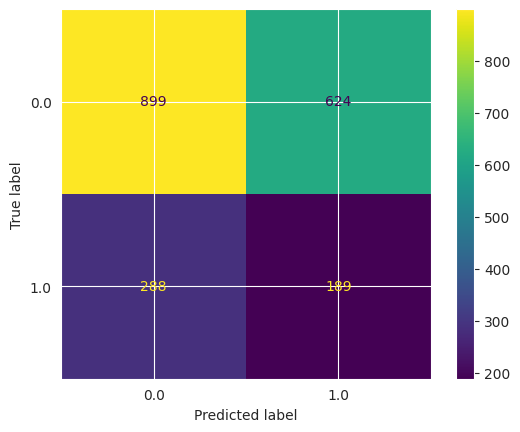

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid, normalize = None)

Gracias al gráfico podemos ver que el módelo ha predicho **acertadamente** 899 veces que los tweet **no contenian profesión**, se ha equivocado 624.

Con los tweet que **contenian profesión, acertó 189** veces mientras que su error fue mayor (283). Esto es debido a que teníamos menos datos de profesión al inicio.

El modelo no es bueno, ya que se equivoca bastante.

In [60]:
# Obtener la importancia de las variables del modelo
importance = model.coef_[0]

In [61]:
# A continuación utilizamos esa variable de importancia de variables, junto a los nombres de las características almacenadas anteriormente en X_columns, para listar la importancia de cada una de las variables.
# Mostrar el número de la característica, con su nombre, y su score de importancia
for i,v in enumerate(importance):
 print('Feature: %0d, Name: %s , Score: %.5f' % (i,X_columns[i],v))


Feature: 0, Name: 100 , Score: -3.53916
Feature: 1, Name: 2020 , Score: -1.26598
Feature: 2, Name: abril , Score: -2.46675
Feature: 3, Name: acaba , Score: 1.26390
Feature: 4, Name: acabar , Score: -1.60702
Feature: 5, Name: actividad , Score: -0.31017
Feature: 6, Name: activos , Score: -4.68296
Feature: 7, Name: actual , Score: -0.16619
Feature: 8, Name: acuerdo , Score: -1.54891
Feature: 9, Name: además , Score: 4.34049
Feature: 10, Name: afectado , Score: -0.60844
Feature: 11, Name: agua , Score: -3.97313
Feature: 12, Name: ahora , Score: -2.09812
Feature: 13, Name: ahí , Score: -1.39330
Feature: 14, Name: aire , Score: -1.30558
Feature: 15, Name: alarma , Score: 0.18579
Feature: 16, Name: alemania , Score: -2.26390
Feature: 17, Name: alguien , Score: -3.28091
Feature: 18, Name: alta , Score: -1.06303
Feature: 19, Name: amigo , Score: -1.00957
Feature: 20, Name: ancianos , Score: 0.97540
Feature: 21, Name: andalucía , Score: -0.66749
Feature: 22, Name: anticuerpos , Score: -2.95381


Podemos ver las variables que más importancia tienen cuando se menciona a un profesional son, por ejemplo:

- Feature: 337, Name: médico , Score: 22.22971
- Feature: 547, Name: trabajadore , Score: 17.81058
- Feature: 481, Name: sanitario , Score: 13.35793
- Feature: 392, Name: personal , Score: 10.07754


Las que tiene menos importancia para nuestro modelo son por ejemplo:

- Feature: 596, Name: últimas , Score: -5.78314
- Feature: 567, Name: usa , Score: -2.67423
- Feature: 537, Name: todas , Score: -5.37558

Las que tiene **menos importancia** son **verbos o sustantivos**.